# 目的
テキスト特徴量を諸々追加する

In [44]:
# path setting
EXP_NAME = "e152-slp-char-tfidf"
MODEL_NAME = "lightgbm"
COMPETITION_NAME = "automated_essay_scoring"

DATA_PATH = "data"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"

N_FOLD = 3

# experiment parameter
DEBUG = False
TRAINING = True
UPLOAD_DATA_TO_S3 = True
UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
SEED = 42
EPOCH = 4
LR = 2e-05

In [45]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

In [46]:
!python --version

Python 3.11.7


In [47]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return f"../../{base_path}"
    elif cwd.startswith("/Users"):
        print("Local Mac!")
        return f"../../{base_path}"
    else:
        raise Exception("Unknown environment")


DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)

/Users/shinichiro.saito/automated_essay_scoring/automated_essay_scoring/exp
Local Mac!
../../data
/Users/shinichiro.saito/automated_essay_scoring/automated_essay_scoring/exp
Local Mac!
../../trained_models/e152-slp-char-tfidf


In [48]:
import os

os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)

# import

In [49]:
%pip install -qq polars==0.20.23
%pip install -qq transformers==4.40.1
%pip install -qq datasets==2.19.0
%pip install -qq evaluate==0.4.2
%pip install -qq seqeval==1.2.2
%pip install -qq accelerate==0.30.0
%pip install -qq python-dotenv==1.0.1
%pip install -qq wandb==0.16.6

# formatter
%pip install -qq black isort

%pip install -qq kaggle

%pip install lightgbm==4.4.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [50]:
import random
import os
import numpy as np
import scipy as sp
import torch
import json
import re
import spacy
import polars as pl
import lightgbm as lgb
from functools import partial
from lightgbm import log_evaluation, early_stopping
import wandb
from sklearn.metrics import cohen_kappa_score
import pickle

In [51]:
# Seed the same seed to all
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [52]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

In [53]:
# with open(f"{DATA_PATH}/essay_id_spelling_errors_cnt.json", "r") as f:
with open(f"{DATA_PATH}/essay_id_spelling_errors_cnt_pyspell.json", "r") as f:
    essay_id_spelling_errors_cnt = json.load(f)

# Wandb

In [54]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project="automated_essay_scoring", name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


'wandb'

# Data Import

In [55]:
train = pl.read_csv(f"{DATA_PATH}/train.csv")

In [56]:
train.head()

essay_id,full_text,score
str,str,i64
"""000d118""","""Many people have car where the…",3
"""000fe60""","""I am a scientist at NASA that …",3
"""001ab80""","""People always wish they had th…",4
"""001bdc0""","""We all heard about Venus, the …",4
"""002ba53""","""Dear, State Senator This is a…",3


# Add Fold

In [57]:
# with open(f"{DATA_PATH}/essay_id_fold_by_s_sl_g_p_only_train_dict.json") as f:
#     essay_id_fold_only_train = json.load(f)

with open(f"{DATA_PATH}/essay_id_fold_by_slp_only_train_dict.json") as f:
    essay_id_fold_only_train = json.load(f)

# with open(f"{DATA_PATH}/essay_id_fold_by_slp_only_persuade_dict.json") as f:
#     essay_id_fold_only_persuade = json.load(f)

In [58]:
train = train.with_columns(
    pl.col("essay_id")
    .replace(essay_id_fold_only_train, return_dtype=pl.Int64)
    .alias("fold")
)

# Add Predict

In [59]:
oof_e057 = pl.read_csv(f"{DATA_PATH}/e057-cv-slp/oof.csv").rename(
    {"valid_pred": "e057_xsmall_oof"}
)
train = train.join(oof_e057, on="essay_id", how="left")

In [60]:
oof_e058 = pl.read_csv(f"{DATA_PATH}/e058-cv-slp/oof.csv").rename(
    {"valid_pred": "e058_small_oof"}
)
train = train.join(oof_e058, on="essay_id", how="left")

In [61]:
oof_e059 = pl.read_csv(f"{DATA_PATH}/e059-cv-slp/oof.csv").rename(
    {"valid_pred": "e059_base_oof"}
)
train = train.join(oof_e059, on="essay_id", how="left")

In [62]:
# oof_e056 = pl.read_csv(f"{DATA_PATH}/e056-cv-w-oof/oof.csv").rename(
#     {"valid_pred": "e056_large_oof"}
# )
# train = train.join(oof_e056, on="essay_id", how="left")

# Feature Engineering

In [63]:
%pip install textstat==0.7.3


[notice] A new release of pip is available: 23.3.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [64]:
import textstat

assert textstat.__version__ == tuple((0, 7, 2))

In [65]:
def get_text_length() -> pl.Expr:
    return pl.col("full_text").str.len_chars().alias("text_length")


def get_word_length() -> pl.Expr:
    return (
        pl.col("full_text")
        .map_elements(lambda x: len(x.split()), return_dtype=pl.Int64)
        .alias("word_length")
    )


def count_spelling_errors() -> pl.Expr:
    return (
        pl.col("essay_id")
        .replace(essay_id_spelling_errors_cnt, return_dtype=pl.Int64)
        .alias("spelling_errors_cnt")
    )


def rate_spelling_errors_per_word() -> pl.Expr:
    return (pl.col("spelling_errors_cnt") / pl.col("word_length")).alias(
        "rate_spelling_errors_per_word"
    )


train = train.with_columns(
    get_text_length(), get_word_length(), count_spelling_errors()
).with_columns(rate_spelling_errors_per_word())

train.head()

essay_id,full_text,score,fold,e057_xsmall_oof,e058_small_oof,e059_base_oof,text_length,word_length,spelling_errors_cnt,rate_spelling_errors_per_word
str,str,i64,i64,f64,f64,f64,u32,i64,i64,f64
"""000d118""","""Many people have car where the…",3,0,1.8652344,2.0136719,1.8837891,2677,498,22,0.044177
"""000fe60""","""I am a scientist at NASA that …",3,2,2.9707031,2.7148438,2.7285156,1669,332,5,0.01506
"""001ab80""","""People always wish they had th…",4,2,4.3984375,4.3242188,4.234375,3077,550,7,0.012727
"""001bdc0""","""We all heard about Venus, the …",4,2,3.6640625,3.6699219,3.1171875,2701,451,6,0.013304
"""002ba53""","""Dear, State Senator This is a…",3,1,2.7851562,2.671875,2.8300781,2208,373,10,0.02681


In [66]:
import pandas as pd


def textstat_features(text):
    features = {}
    features["flesch_reading_ease"] = textstat.flesch_reading_ease(text)
    features["flesch_kincaid_grade"] = textstat.flesch_kincaid_grade(text)
    features["smog_index"] = textstat.smog_index(text)
    features["coleman_liau_index"] = textstat.coleman_liau_index(text)
    features["automated_readability_index"] = textstat.automated_readability_index(text)
    features["dale_chall_readability_score"] = textstat.dale_chall_readability_score(
        text
    )
    features["difficult_words"] = textstat.difficult_words(text)
    features["linsear_write_formula"] = textstat.linsear_write_formula(text)
    features["gunning_fog"] = textstat.gunning_fog(text)
    features["text_standard"] = textstat.text_standard(text, float_output=True)
    features["spache_readability"] = textstat.spache_readability(text)
    features["mcalpine_eflaw"] = textstat.mcalpine_eflaw(text)
    features["reading_time"] = textstat.reading_time(text)
    features["syllable_count"] = textstat.syllable_count(text)
    features["lexicon_count"] = textstat.lexicon_count(text)
    features["monosyllabcount"] = textstat.monosyllabcount(text)

    return features


train_text_stat_df = pl.DataFrame(
    train["full_text"].to_pandas().apply(textstat_features).tolist()
)

train = pl.concat([train, train_text_stat_df], how="horizontal")

In [67]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [68]:
nlp = spacy.load("en_core_web_sm")
from collections import Counter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.auto import tqdm

tqdm.pandas()
# nltk.download()


def extract_linguistic_features(text):

    doc = nlp(text)
    features = {}

    # NER Features
    entity_counts = {
        "GPE": 0,
        "PERCENT": 0,
        "NORP": 0,
        "ORG": 0,
        "CARDINAL": 0,
        "MONEY": 0,
        "DATE": 0,
        "LOC": 0,
        "PERSON": 0,
        "QUANTITY": 0,
        "EVENT": 0,
        "ORDINAL": 0,
        "WORK_OF_ART": 0,
        "LAW": 0,
        "PRODUCT": 0,
        "TIME": 0,
        "FAC": 0,
        "LANGUAGE": 0,
    }
    for entity in doc.ents:
        if entity.label_ in entity_counts:
            entity_counts[entity.label_] += 1
    features["NER_Features"] = entity_counts

    # POS Features
    pos_counts = {
        "ADJ": 0,
        "NOUN": 0,
        "VERB": 0,
        "SCONJ": 0,
        "PRON": 0,
        "PUNCT": 0,
        "DET": 0,
        "AUX": 0,
        "PART": 0,
        "ADP": 0,
        "SPACE": 0,
        "CCONJ": 0,
        "PROPN": 0,
        "NUM": 0,
        "ADV": 0,
        "SYM": 0,
        "INTJ": 0,
        "X": 0,
    }
    for token in doc:
        if token.pos_ in pos_counts:
            pos_counts[token.pos_] += 1
    features["POS_Features"] = pos_counts

    # tag Features
    tags = {
        "RB": 0,
        "-RRB-": 0,
        "PRP$": 0,
        "JJ": 0,
        "TO": 0,
        "VBP": 0,
        "JJS": 0,
        "DT": 0,
        "''": 0,
        "UH": 0,
        "RBS": 0,
        "WRB": 0,
        ".": 0,
        "HYPH": 0,
        "XX": 0,
        "``": 0,
        "SYM": 0,
        "VB": 0,
        "VBN": 0,
        "WP": 0,
        "CC": 0,
        "LS": 0,
        "POS": 0,
        "NN": 0,
        ",": 0,
        "NNPS": 0,
        "RP": 0,
        ":": 0,
        "$": 0,
        "PDT": 0,
        "VBZ": 0,
        "VBD": 0,
        "JJR": 0,
        "-LRB-": 0,
        "IN": 0,
        "RBR": 0,
        "WDT": 0,
        "EX": 0,
        "MD": 0,
        "_SP": 0,
        "NNP": 0,
        "CD": 0,
        "VBG": 0,
        "NNS": 0,
        "PRP": 0,
    }

    for token in doc:
        if token.tag_ in tags:
            tags[token.tag_] += 1
    features["tag_Features"] = tags

    # tense features
    tenses = [i.morph.get("Tense") for i in doc]
    tenses = [i[0] for i in tenses if i]
    tense_counts = Counter(tenses)
    features["past_tense_ratio"] = tense_counts.get("Past", 0) / (
        tense_counts.get("Pres", 0) + tense_counts.get("Past", 0) + 1e-5
    )
    features["present_tense_ratio"] = tense_counts.get("Pres", 0) / (
        tense_counts.get("Pres", 0) + tense_counts.get("Past", 0) + 1e-5
    )

    # len features

    features["word_count"] = len(doc)
    features["sentence_count"] = len([sentence for sentence in doc.sents])
    features["words_per_sentence"] = features["word_count"] / features["sentence_count"]
    features["std_words_per_sentence"] = np.std(
        [len(sentence) for sentence in doc.sents]
    )

    features["unique_words"] = len(set([token.text for token in doc]))
    features["lexical_diversity"] = features["unique_words"] / features["word_count"]

    paragraph = text.split("\n\n")

    features["paragraph_count"] = len(paragraph)

    features["avg_chars_by_paragraph"] = np.mean(
        [len(paragraph) for paragraph in paragraph]
    )
    features["avg_words_by_paragraph"] = np.mean(
        [len(nltk.word_tokenize(paragraph)) for paragraph in paragraph]
    )
    features["avg_sentences_by_paragraph"] = np.mean(
        [len(nltk.sent_tokenize(paragraph)) for paragraph in paragraph]
    )

    # sentiment features
    analyzer = SentimentIntensityAnalyzer()
    sentences = nltk.sent_tokenize(text)

    compound_scores, negative_scores, positive_scores, neutral_scores = [], [], [], []
    for sentence in sentences:
        scores = analyzer.polarity_scores(sentence)
        compound_scores.append(scores["compound"])
        negative_scores.append(scores["neg"])
        positive_scores.append(scores["pos"])
        neutral_scores.append(scores["neu"])

    features["mean_compound"] = np.mean(compound_scores)
    features["mean_negative"] = np.mean(negative_scores)
    features["mean_positive"] = np.mean(positive_scores)
    features["mean_neutral"] = np.mean(neutral_scores)

    features["std_compound"] = np.std(compound_scores)
    features["std_negative"] = np.std(negative_scores)
    features["std_positive"] = np.std(positive_scores)
    features["std_neutral"] = np.std(neutral_scores)

    return features


# train_linguistic = pl.DataFrame(
#     pd.json_normalize(
#         train.to_pandas()["full_text"].progress_apply(extract_linguistic_features)
#     )
# )

train_linguistic = pl.read_csv(f"{DATA_PATH}/e106/train_linguistic.csv")

# LightGBMように変数名を修正
train_linguistic = train_linguistic.rename(
    {
        "tag_Features.,": "tag_Features.comma",
        "tag_Features.PRP$": "tag_Features.PRP_doll",
        "tag_Features.PRP$": "tag_Features.PRP_doll",
        "tag_Features.''": "tag_Features.sinqle_quote",
        "tag_Features..": "tag_Features.dot",
        "tag_Features.``": "tag_Features.quotation",
        "tag_Features.:": "tag_Features.semicoron",
        "tag_Features.$": "tag_Features.doll",
    }
)

train = pl.concat([train, train_linguistic], how="horizontal")

## feedback feature

In [69]:
LOAD_FEEDBACK_FEATURE = True

In [70]:
from sentence_transformers import SentenceTransformer, models

In [71]:
import sentence_transformers

sentence_transformers.__version__

'2.2.2'

In [72]:
if not LOAD_FEEDBACK_FEATURE:
    feedback_df = pd.read_csv(f"{DATA_PATH}/e106/feedback-data/feedback_data.csv")

    feed_embeds = []

    merged_embeds = []

    test_embeds = []

    for i in range(5):
        model_path = f"{DATA_PATH}/e106/sent-debsmall/deberta_small_trained/temp_fold{i}_checkpoints"
        word_embedding_model = models.Transformer(model_path, max_seq_length=1024)
        pooling_model = models.Pooling(
            word_embedding_model.get_word_embedding_dimension()
        )
        model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

        model.half()
        model = model.to("cuda")

        feed_custom_embeddings_train = model.encode(
            feedback_df.loc[:, "full_text"].values,
            device="cuda",
            show_progress_bar=True,
            normalize_embeddings=True,
        )

        feed_embeds.append(feed_custom_embeddings_train)

        merged_custom_embeddings = model.encode(
            train.to_pandas().loc[:, "full_text"].values,
            device="cuda",
            show_progress_bar=True,
            normalize_embeddings=True,
        )

        merged_embeds.append(merged_custom_embeddings)

    #     test_custom_embeddings = model.encode(
    #         test.loc[:, "full_text"].values,
    #         device="cuda",
    #         show_progress_bar=True,
    #         normalize_embeddings=True,
    #     )

    #     test_embeds.append(test_custom_embeddings)

    feed_embeds = np.mean(feed_embeds, axis=0)
    merged_embeds = np.mean(merged_embeds, axis=0)
    # test_embeds = np.mean(test_embeds, axis=0)

    from sklearn.linear_model import Ridge
    from sklearn.multioutput import MultiOutputRegressor

    targets = [
        "cohesion",
        "syntax",
        "vocabulary",
        "phraseology",
        "grammar",
        "conventions",
    ]

    ridge = Ridge(alpha=1.0)

    multioutputregressor = MultiOutputRegressor(ridge)
    multioutputregressor.fit(feed_embeds, feedback_df.loc[:, targets])

    with open(f"{MODEL_OUTPUT_PATH}/fb_ridge.pkl", "wb") as file:
        pickle.dump(multioutputregressor, file)

    feedback_predictions = multioutputregressor.predict(merged_embeds)

    feedback_predictions_df = pd.DataFrame(feedback_predictions, columns=targets)

    # test_feedback_predictions = multioutputregressor.predict(test_embeds)
    # test_feedback_predictions_df = pd.DataFrame(test_feedback_predictions, columns=targets)

    feedback_predictions_df.head()

    feedback_predictions_df.to_csv(
        f"{DATA_PATH}/e106/feedback-data/feedback_predictions.csv"
    )
else:
    feedback_predictions_df = pd.read_csv(
        f"{DATA_PATH}/e106/feedback-data/feedback_predictions.csv"
    )

In [73]:
feedback_predictions_df.columns

Index(['Unnamed: 0', 'cohesion', 'syntax', 'vocabulary', 'phraseology',
       'grammar', 'conventions'],
      dtype='object')

In [74]:
train = pl.concat([train, pl.from_pandas(feedback_predictions_df)], how="horizontal")

# tfidf

In [75]:
tfidf_oof = pl.read_csv("../../trained_models/e-char-tfidf-slp/oof_tfidf.csv")

In [76]:
train = train.join(tfidf_oof, on="essay_id", how="left")

# Training

In [77]:
TARGET_COL = "score"
USE_COL = [
    "e057_xsmall_oof",
    "e058_small_oof",
    "e059_base_oof",
    "text_length",
    "word_length",
    "spelling_errors_cnt",
    "rate_spelling_errors_per_word",
]

USE_COL += [
    "flesch_reading_ease",
    "flesch_kincaid_grade",
    "smog_index",
    "coleman_liau_index",
    "automated_readability_index",
    "dale_chall_readability_score",
    "difficult_words",
    "linsear_write_formula",
    "gunning_fog",
    "text_standard",
    "spache_readability",
    "mcalpine_eflaw",
    "reading_time",
    "syllable_count",
    "lexicon_count",
    "monosyllabcount",
]

USE_COL += [
    "past_tense_ratio",
    "present_tense_ratio",
    "word_count",
    "sentence_count",
    "words_per_sentence",
    "std_words_per_sentence",
    "unique_words",
    "lexical_diversity",
    "paragraph_count",
    "avg_chars_by_paragraph",
    "avg_words_by_paragraph",
    "avg_sentences_by_paragraph",
    "mean_compound",
    "mean_negative",
    "mean_positive",
    "mean_neutral",
    "std_compound",
    "std_negative",
    "std_positive",
    "std_neutral",
    "NER_Features.GPE",
    "NER_Features.PERCENT",
    "NER_Features.NORP",
    "NER_Features.ORG",
    "NER_Features.CARDINAL",
    "NER_Features.MONEY",
    "NER_Features.DATE",
    "NER_Features.LOC",
    "NER_Features.PERSON",
    "NER_Features.QUANTITY",
    "NER_Features.EVENT",
    "NER_Features.ORDINAL",
    "NER_Features.WORK_OF_ART",
    "NER_Features.LAW",
    "NER_Features.PRODUCT",
    "NER_Features.TIME",
    "NER_Features.FAC",
    "NER_Features.LANGUAGE",
    "POS_Features.ADJ",
    "POS_Features.NOUN",
    "POS_Features.VERB",
    "POS_Features.SCONJ",
    "POS_Features.PRON",
    "POS_Features.PUNCT",
    "POS_Features.DET",
    "POS_Features.AUX",
    "POS_Features.PART",
    "POS_Features.ADP",
    "POS_Features.SPACE",
    "POS_Features.CCONJ",
    "POS_Features.PROPN",
    "POS_Features.NUM",
    "POS_Features.ADV",
    "POS_Features.SYM",
    "POS_Features.INTJ",
    "POS_Features.X",
    "tag_Features.RB",
    "tag_Features.-RRB-",
    "tag_Features.PRP_doll",
    "tag_Features.JJ",
    "tag_Features.TO",
    "tag_Features.VBP",
    "tag_Features.JJS",
    "tag_Features.DT",
    "tag_Features.sinqle_quote",
    "tag_Features.UH",
    "tag_Features.RBS",
    "tag_Features.WRB",
    "tag_Features.dot",
    "tag_Features.HYPH",
    "tag_Features.XX",
    "tag_Features.quotation",
    "tag_Features.SYM",
    "tag_Features.VB",
    "tag_Features.VBN",
    "tag_Features.WP",
    "tag_Features.CC",
    "tag_Features.LS",
    "tag_Features.POS",
    "tag_Features.NN",
    "tag_Features.comma",
    "tag_Features.NNPS",
    "tag_Features.RP",
    "tag_Features.semicoron",
    "tag_Features.doll",
    "tag_Features.PDT",
    "tag_Features.VBZ",
    "tag_Features.VBD",
    "tag_Features.JJR",
    "tag_Features.-LRB-",
    "tag_Features.IN",
    "tag_Features.RBR",
    "tag_Features.WDT",
    "tag_Features.EX",
    "tag_Features.MD",
    "tag_Features._SP",
    "tag_Features.NNP",
    "tag_Features.CD",
    "tag_Features.VBG",
    "tag_Features.NNS",
    "tag_Features.PRP",
]

USE_COL += ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
USE_COL += [col for col in tfidf_oof.columns if col != "essay_id"]

In [78]:
# LightGBMで用いるパラメータを指定
params = {
    "objective": "regression",
    "metric": "rmse",
    "max_depth": -1,
    "min_data_in_leaf": 10,  # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.01,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.7,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.6,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、-1はFatalなログのみを出力
    "seed": SEED,  # ランダムシードの固定
    "lambda_l1": 0.4,  # 正則化のためのパラメータ
    "lambda_l2": 0.4,  # 正則化のためのパラメータ
}

In [79]:
models = []
oofs = []

# Cross Validationによる学習の実施
for fold in range(N_FOLD):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train.filter(pl.col("fold") != fold)
    valid_fold = train.filter(pl.col("fold") == fold)

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.select(USE_COL)
    X_valid = valid_fold.select(USE_COL)
    y_train = train_fold.select(TARGET_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # LightGBMが認識可能な形にデータセットを変換
    # polars.DataFrame から pandas.DataFrame への変更を行っている
    lgb_train = lgb.Dataset(X_train.to_pandas(), y_train.to_pandas())
    lgb_eval = lgb.Dataset(
        X_valid.to_pandas(), y_valid.to_pandas(), reference=lgb_train
    )

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            early_stopping(
                stopping_rounds=100
            ),  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
            log_evaluation(100),  # 指定したiteration回数ごとにlogを出力する
        ],
    )

    with open(f"{MODEL_OUTPUT_PATH}/model_{fold}.pkl", "wb") as f:
        pickle.dump(model, f)

    # モデルを保存
    models.append([fold, model])

    # valid データに対する推論
    y_valid_pred = model.predict(X_valid.to_pandas())

    # OOF に推論結果を保存
    oof_per_fold = valid_fold.select("score").with_columns(
        pl.Series(y_valid_pred).alias("valid_pred")
    )
    oofs.append(oof_per_fold)

oof = pl.concat(oofs)

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.612764	valid_1's rmse: 0.625063
[200]	training's rmse: 0.51314	valid_1's rmse: 0.537228
[300]	training's rmse: 0.485329	valid_1's rmse: 0.521404
[400]	training's rmse: 0.470141	valid_1's rmse: 0.51831
[500]	training's rmse: 0.457787	valid_1's rmse: 0.517855
[600]	training's rmse: 0.446744	valid_1's rmse: 0.517969
Early stopping, best iteration is:
[514]	training's rmse: 0.456233	valid_1's rmse: 0.517788
Start fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.612857	valid_1's rmse: 0.621027
[200]	training's rmse: 0.513358	valid_1's rmse: 0.535477
[300]	training's rmse: 0.485593	valid_1's rmse: 0.521398
[400]	training's rmse: 0.47065	valid_1's rmse: 0.51907
[500]	training's rmse: 0.458159	valid_1's rmse: 0.518993
Early stopping, best iteration is:
[484]	training's rmse: 0.460008	valid_1's rmse: 0.518796
Start fold 2
Training until validation scor

# 特徴量重要度の計算

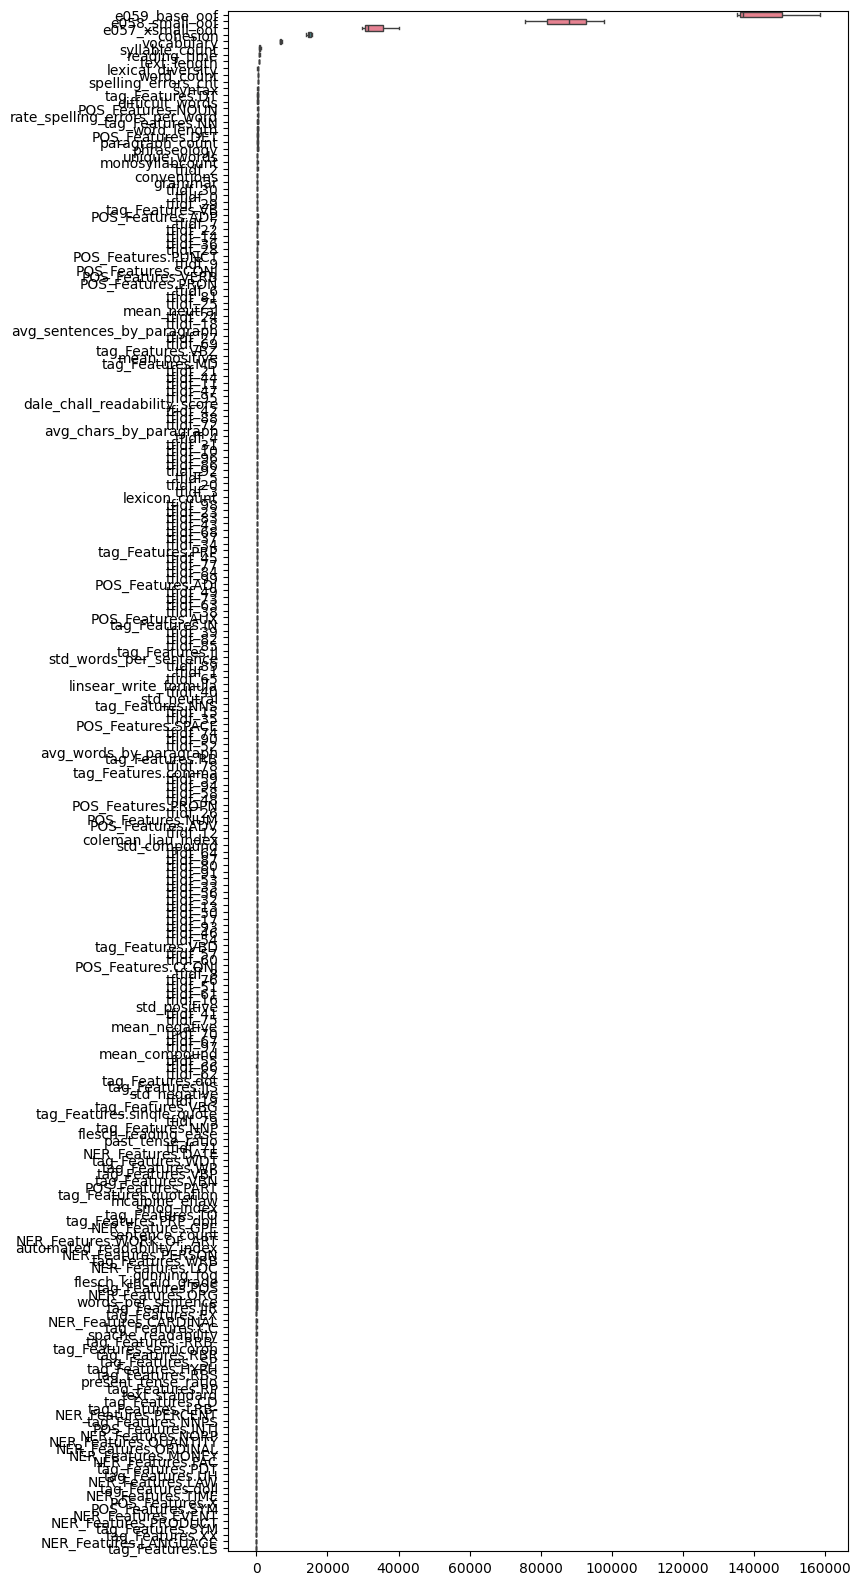

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.feature_importance(importance_type="gain") for _, model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

# 表示する順番を指定、特徴量重要度の平均が大きい順に並ぶよう計算
order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
plt.figure(figsize=(8, 20))
sns.boxplot(data=feature_importances_df, orient="h", order=order)
plt.savefig(f"{MODEL_OUTPUT_PATH}/feature_importance.png")

# CVの計算

In [81]:
cv_score = cohen_kappa_score(
    oof["score"],
    np.clip(oof["valid_pred"], 1, 6).round(),
    weights="quadratic",
)
print(f"OOF CV Score by round: {cv_score}")

OOF CV Score by round: 0.8294605791219763


In [82]:
# https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5#optimizedrounder
class OptimizedRounder:
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6

        ll = cohen_kappa_score(y, X_p, weights="quadratic")
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [1.5, 2.5, 3.5, 4.5, 5.5]
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method="nelder-mead"
        )

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6
        return X_p

    @property
    def coefficients(self):
        return self.coef_["x"]

In [83]:
optR = OptimizedRounder()
optR.fit(oof["valid_pred"], oof["score"])
print(optR.coefficients)

optimized_valid_pred = optR.predict(oof["valid_pred"], optR.coefficients)
np.save(f"{MODEL_OUTPUT_PATH}/opt_thr.npy", optR.coefficients)

cv_score = cohen_kappa_score(oof["score"], optimized_valid_pred, weights="quadratic")

print(f"OOF CV Score by NelderMead: {cv_score}")

# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

[1.66223114 2.55702003 3.39452973 4.23935664 5.16130404]
OOF CV Score by NelderMead: 0.8405394088505209


# 混同行列の計算

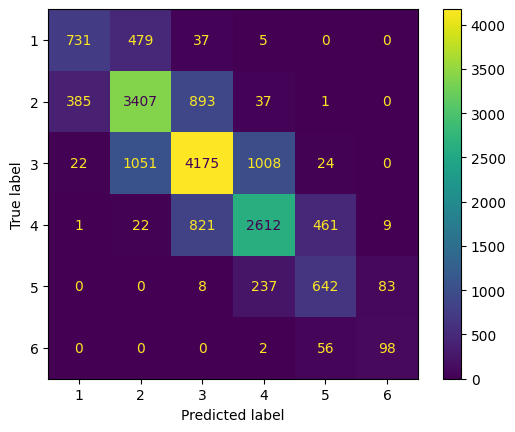

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    oof["score"],
    optimized_valid_pred,
    labels=[x for x in range(1, 7)],
)

draw_cm = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
)

draw_cm.plot()
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png")
plt.show()

# Kaggleへのアップロード

In [85]:
if UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{DATASET_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=DATASET_NAME, upload_dir=MODEL_OUTPUT_PATH)

Create Dataset name:e152-slp-char-tfidf-lightgbm, output_dir:../../trained_models/e152-slp-char-tfidf
Starting upload for file confusion_matrix.png


100%|██████████| 32.1k/32.1k [00:00<00:00, 40.3kB/s]


Upload successful: confusion_matrix.png (32KB)
Starting upload for file opt_thr.npy


100%|██████████| 168/168 [00:00<00:00, 192B/s]


Upload successful: opt_thr.npy (168B)
Starting upload for file cv_score.txt


100%|██████████| 18.0/18.0 [00:00<00:00, 23.5B/s]


Upload successful: cv_score.txt (18B)
Starting upload for file feature_importance.png


100%|██████████| 262k/262k [00:01<00:00, 254kB/s] 


Upload successful: feature_importance.png (262KB)
Starting upload for file model_1.pkl


100%|██████████| 1.10M/1.10M [00:01<00:00, 865kB/s]


Upload successful: model_1.pkl (1MB)
Starting upload for file model_0.pkl


100%|██████████| 1.17M/1.17M [00:01<00:00, 870kB/s]


Upload successful: model_0.pkl (1MB)
Starting upload for file model_2.pkl


100%|██████████| 1.15M/1.15M [00:02<00:00, 565kB/s]


Upload successful: model_2.pkl (1MB)
